In [1]:
from google.colab import drive 
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [14]:
# declare the libs, modules | khai bao thu vien
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import keras
from keras.models import Model, load_model, Sequential
from tensorflow.keras import Input
from keras.layers import Dense, Flatten
from keras.datasets import mnist
from keras.utils import np_utils
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
import seaborn as sns

#Load the MNIST dataset | Tai bo du lieu anh chu viet tay MNIST

In [15]:
# Lấy data train và test trong bộ mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# Đếm dữ liệu cho train với test
print("Number of image for training: {}".format(len(x_train)))
print("Number of image for testing: {}".format(len(x_test)))

Number of image for training: 60000
Number of image for testing: 10000


#Split a part of train set for a validation set

In [16]:
# Chia tập validation với tỉ lệ 4:1 với tập train
x_val, y_val = x_train[48000:60000, :, :], y_train[48000:60000]
x_train, y_train = x_train[:48000, :, :], y_train[:48000]
print("Number of image for training: {}".format(len(x_train)))
print("Number of image for validating: {}".format(len(x_val)))

Number of image for training: 48000
Number of image for validating: 12000


#Show samples for instances in dataset

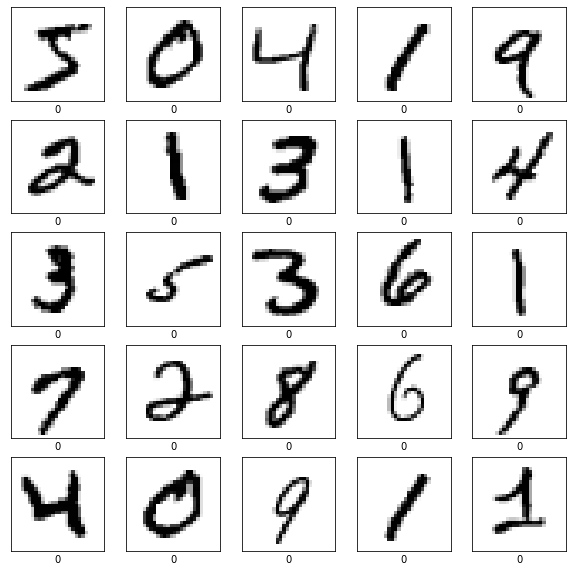

In [17]:
# Hiển thị 25 hình ảnh trong bộ Mnist
plt.figure(figsize=(10, 10))
for i in range (25):
  # Vẽ ảnh vào lần lượt các ô trong 25 ô từ trái qua phải trên xuống dưới
  # ví dụ plt.subplot(6, 6, i + 1) thì điền lần lượt 36 ô từ trái qua phải từ trên xuống dưới
  plt.subplot(5, 5, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(x_train[i], cmap = plt.cm.binary)
  # Các vector trong y_train hay là nhãn của tập huấn luyện có dạng [1, 0, 0,.., 0] thì vị trí của số 1 là thuộc lớp ý 
  # Ví dụ 9 số và dữ liệu A = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0] thì np.argmax trả ra vị trí có giá trị cao nhất
  # Do đó vị trí cao nhất trong A là 2 thì A thuộc class số 2 (tức là số 2)
  plt.xlabel(np.argmax(y_train[i]))
plt.show()

#Data processing

In [18]:
# Bước này mình chuyển shape của các array 
# Ví dụ: x_train shape ban đầu (60000, 28, 28) chuyển thành (60000, 28, 28, 1)
# (28, 28, 3)
x_train = x_train.reshape((x_train.shape[0], 28, 28, 1))
x_val = x_val.reshape((x_val.shape[0], 28, 28, 1))
x_test = x_test.reshape((x_test.shape[0], 28, 28, 1))

# Chuẩn hóa dữ liệu theo MinMaxScaler (do trong pixel thì cao nhất 255 còn nhỏ nhất là 0) nên có công thức ở dưới
# Công thức đầy đủ chuyển từ [0, 255] sang [0, 1]
# x_moi = (x_cu - min)/(max - min) = (x_cu - 0)/(255 - 0) nên ta có công thức dưới
x_train = x_train/255.0
x_val = x_val/255.0
x_test = x_test/255.0

#Convert label/output to one-hot vector

In [12]:
# Xem qua target
print(y_train[0])

5


In [19]:
# Chuyển các label sang dạng one hot coding
# Ví dụ 4 -> [0 0 0 0 1 0 0 0 0 0]
y_train = np_utils.to_categorical(y_train)
y_val = np_utils.to_categorical(y_val)
y_test = np_utils.to_categorical(y_test)
print(y_train[0])
print(y_test[0])
print(y_val[0])

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


In [ ]:
y_train

#Build the NN model

In [20]:
# Định nghĩa model
# Cái sequence này giống như 1 cái stack (LIFO)
# mọi người hiểu đơn giản như này ví dụ ta có 1 cái stack rỗng [] thì khi add thêm lần lượt a và b vào thì có [b, a]
model = Sequential()
# (28, 28, 3)
model.add(Input(shape = (28, 28, 1)))
# Duỗi ảnh thành dạng vector ví dụ (28, 28, ) --> (784, )
model.add(Flatten())
# Các lớp fully connected thường dùng hàm kích hoạt relu do sigmoid và tanh có thể xảy ra hiện tượng mất mát gradient
# Tuy nhiên trong thực tế vẫn có thể dùng sigmoid vs tanh trong một số bài toán sau này
model.add(Dense(128, activation = "relu"))
model.add(Dense(64, activation = "relu"))
model.add(Dense(64, activation = "relu"))
model.add(Dense(32, activation = "relu"))
model.add(Dense(10, activation = "softmax"))

In [21]:
# Compile mô hình: loss, optimizer, metrics
model.compile(loss = "categorical_crossentropy", optimizer = Adam(learning_rate = 0.001), metrics = ["accuracy"])
# Tóm tắt mô hình
model.summary()

# Tính só tham số (filter_trc + 1) *(filter_sau)

# dense_36 = (784 + 1) x 128 = 100480
# dense_37 (128 + 1) x 64 = 8256

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 10)                330       
                                                                 
Total params: 115,306
Trainable params: 115,306
Non-trai

In [22]:
# Tính step per epoch, validation step
# Kích cỡ 1 batch trong 1 lần huấn luyện
batch_size = 32
steps_per_epoch = 0
validation_step = 0

# Tính các bước trong 1 epoch huấn luyện 
# Do kích cỡ 1 batch là 32 dữ liệu nên số bước là tổng số dữ liệu chia 32 (+ 1 nếu ko chia hết nhưng thực tế đôi khi không cần thiết)
if len(x_train) % 32:
    steps_per_epoch = len(x_train) // 32 + 1
else:
    steps_per_epoch = len(x_train) / 32

if len(x_val) % 32:
    validation_step = len(x_val) // 32 + 1
else:
    validation_step = len(x_val) / 32

# Bắt đầu huấn luyện mô hình 
# model.fit(dữ liệu train, nhãn train, dữ liệu tập xác thực, kích cỡ batch, số epoch, số bước trong 1 epoch trong train, số bước 1 epoch trong val)
history = model.fit(x_train, y_train, validation_data = (x_val, y_val), batch_size = 32, epochs = 20, steps_per_epoch = steps_per_epoch, validation_steps= validation_step)

Epoch 1/20
1500/1500 [==============================] - 10s 6ms/step - loss: 0.2968 - accuracy: 0.9087 - val_loss: 0.1430 - val_accuracy: 0.9580
Epoch 2/20
1500/1500 [==============================] - 6s 4ms/step - loss: 0.1160 - accuracy: 0.9648 - val_loss: 0.1130 - val_accuracy: 0.9662
Epoch 3/20
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0835 - accuracy: 0.9741 - val_loss: 0.1071 - val_accuracy: 0.9708
Epoch 4/20
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0661 - accuracy: 0.9793 - val_loss: 0.0941 - val_accuracy: 0.9708
Epoch 5/20
1500/1500 [==============================] - 7s 4ms/step - loss: 0.0529 - accuracy: 0.9833 - val_loss: 0.0960 - val_accuracy: 0.9743
Epoch 6/20
1500/1500 [==============================] - 6s 4ms/step - loss: 0.0438 - accuracy: 0.9864 - val_loss: 0.1126 - val_accuracy: 0.9729
Epoch 7/20
1500/1500 [==============================] - 8s 5ms/step - loss: 0.0377 - accuracy: 0.9878 - val_loss: 0.1167 - val_accuracy

In [24]:
# Lưu mô hình
model.save("model_0.9956.h5")

In [25]:
# Load lại mô hình đã lưu
model1 = load_model("model_0.9956.h5")
# Kiểm thử mô hình
model1.evaluate(x_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.1038 - accuracy: 0.9790


[0.10381917655467987, 0.9789999723434448]

313/313 [==============================] - 1s 2ms/step


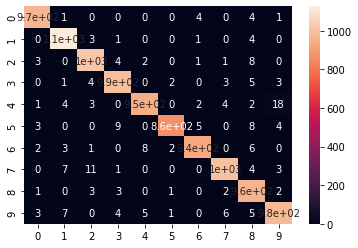

In [26]:
y_pred = np.array([np.argmax(i) for i in model1.predict(x_test)])
y_true = np.array([np.argmax(i) for i in y_test])
# Cái này là confusion matrix (trục tung là giá trị đúng và hoành là đoán ra)
sns.heatmap(confusion_matrix(y_true, y_pred), annot = True)

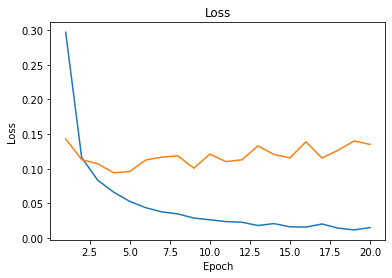

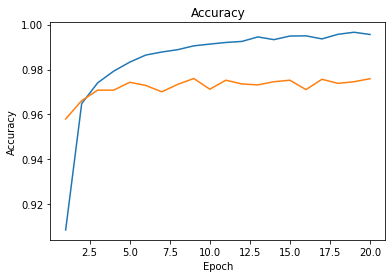

In [27]:
# Vẽ hàm mất mát thay đổi trong huần luyện
numOfEpoch = 20
plt.plot(list(map(int, np.linspace(1, numOfEpoch, 20))), history.history['loss'], label='training loss')
plt.plot(list(map(int, np.linspace(1, numOfEpoch, 20))), history.history['val_loss'], label='validation loss')
plt.title("Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

plt.plot(list(map(int, np.linspace(1, numOfEpoch, 20))), history.history['accuracy'], label='accuracy')
plt.plot(list(map(int, np.linspace(1, numOfEpoch, 20))), history.history['val_accuracy'], label='validation accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()